*Data Science for Business 1*

# Group Project: Loan approval model

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import itertools

#Libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image

#Library for building machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection
import optuna
from optuna.integration import OptunaSearchCV
from xgboost import XGBClassifier

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt

from scipy.stats import loguniform, expon
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

## Import data

In [2]:
loans = pd.read_csv("loan_approval_dataset.csv")
loans.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## Data exploration and summary statistics

In [3]:
loans.shape

(4269, 13)

The dataset has 4269 rows and 13 columns.

In [4]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


There are no missing values. The most of the columns are integer Dtype but there are three columns with Dtype object.

In [5]:
loans.describe().round()

,loan_id,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0,4269.0
mean,2135.0,2.0,5059124.0,15133450.0,11.0,600.0,7472617.0,4973155.0,15126306.0,4976692.0
std,1232.0,2.0,2806840.0,9043363.0,6.0,172.0,6503637.0,4388966.0,9103754.0,3250185.0
min,1.0,0.0,200000.0,300000.0,2.0,300.0,-100000.0,0.0,300000.0,0.0
25%,1068.0,1.0,2700000.0,7700000.0,6.0,453.0,2200000.0,1300000.0,7500000.0,2300000.0
50%,2135.0,3.0,5100000.0,14500000.0,10.0,600.0,5600000.0,3700000.0,14600000.0,4600000.0
75%,3202.0,4.0,7500000.0,21500000.0,16.0,748.0,11300000.0,7600000.0,21700000.0,7100000.0
max,4269.0,5.0,9900000.0,39500000.0,20.0,900.0,29100000.0,19400000.0,39200000.0,14700000.0


In [6]:
loans.select_dtypes(include="object")

,education,self_employed,loan_status
0,Graduate,No,Approved
1,Not Graduate,Yes,Rejected
2,Graduate,No,Rejected
3,Graduate,No,Rejected
4,Not Graduate,Yes,Rejected
...,...,...,...
4264,Graduate,Yes,Rejected
4265,Not Graduate,Yes,Approved
4266,Not Graduate,No,Rejected
4267,Not Graduate,No,Approved


## Data preprocessing

In [7]:
loans.columns = loans.columns.str.strip()
loans.drop("loan_id", axis=1, inplace=True)
loans.drop("cibil_score", axis=1, inplace=True) # Only consider 1st time applicants

loans['education'] = loans['education'].str.strip()
loans['self_employed'] = loans['self_employed'].str.strip()
loans['loan_status'] = loans['loan_status'].str.strip()

loans["education"] = loans["education"].replace({"Graduate" : 1, "Not Graduate" : 0})
loans["self_employed"] = loans["self_employed"].replace({"Yes" : 1, "No" : 0})
loans["loan_status"] = loans["loan_status"].replace({"Approved" : 1, "Rejected" : 0})

loans.head()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,2,1,0,9600000,29900000,12,2400000,17600000,22700000,8000000,1
1,0,0,1,4100000,12200000,8,2700000,2200000,8800000,3300000,0
2,3,1,0,9100000,29700000,20,7100000,4500000,33300000,12800000,0
3,3,1,0,8200000,30700000,8,18200000,3300000,23300000,7900000,0
4,5,0,1,9800000,24200000,20,12400000,8200000,29400000,5000000,0


## Checking the target class distribution

From the visualization we can see that the loan is "Approved" in 2656 cases so in 62.2% of the cases and "Rejected" in 1613 cases so in 37.8%% of the cases. Most of the credit applications in the dataset are approved.

loan_status
1    2656
0    1613
Name: count, dtype: int64


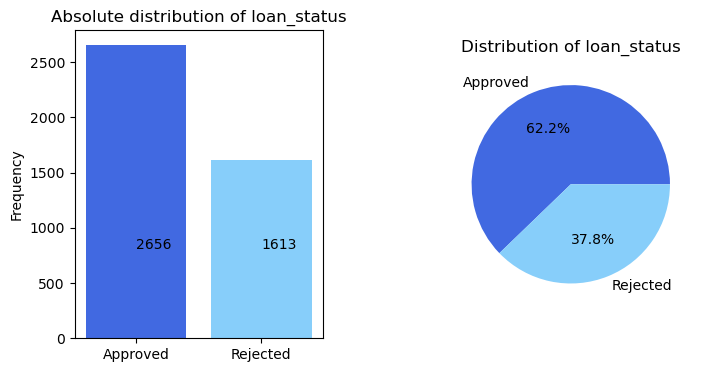

In [8]:
class_counts=loans["loan_status"].value_counts()
print(class_counts)

plt.figure(figsize=(8, 4))
           
plt.subplot(1,2,1)
plt.bar(["Approved", "Rejected"], class_counts, color = ["royalblue", "lightskyblue"])
plt.title("Absolute distribution of loan_status")
plt.ylabel("Frequency")
plt.text(["Approved"], class_counts[0]/2, class_counts[1])
plt.text(["Rejected"], class_counts[0]/2, class_counts[0])

plt.subplot(1,2,2)
plt.pie(class_counts, labels=["Approved", "Rejected"], autopct="%1.1f%%", colors= ["royalblue", "lightskyblue"])
plt.title("Distribution of loan_status")

plt.subplots_adjust(wspace=0.5)
plt.show()

## Separating the data to features X and labels y

In [9]:
X = loans.drop(["loan_status"], axis=1)
y = loans["loan_status"]

## Train test split

In [10]:
# One-hot encode no_of_dependents
X_onehot = pd.get_dummies(X, columns=["no_of_dependents"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_onehot)

# Split training and testing
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1234, test_size=0.3)

In [11]:
smote = SMOTE(sampling_strategy='minority', random_state=1234)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train) #applied only to training

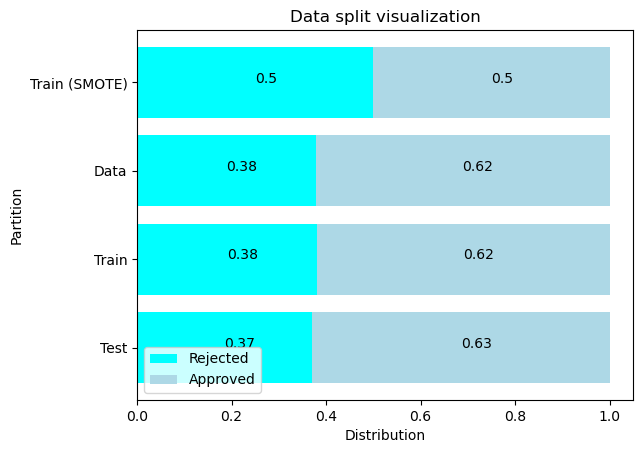

In [12]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
loans_dist = loans["loan_status"].value_counts() / len(loans)
smote_dist = pd.Series(y_train_balanced).value_counts() / len(pd.Series(y_train_balanced))

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data', 'Train (SMOTE)'], [ test_dist[0], train_dist[0], loans_dist[0], smote_dist[0]], color='cyan', label='Rejected')
ax.barh(['Test','Train','Data', 'Train (SMOTE)'], [ test_dist[1], train_dist[1], loans_dist[1], smote_dist[1]], left=[ test_dist[0], train_dist[0], loans_dist[0], smote_dist[0]], color='lightblue', label='Approved')
ax.set_title('Data split visualization')
ax.legend(loc='lower left')
plt.xlabel('Distribution')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip([ 'Test', 'Train','Data', 'Train (SMOTE)'], [ test_dist[0], train_dist[0], loans_dist[0], smote_dist[0]], [test_dist[1], train_dist[1], loans_dist[1], smote_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## Imbalanced decision tree

In [13]:
dt = tree.DecisionTreeClassifier(criterion = "gini", random_state = 1234, max_depth=5, min_samples_leaf=5).fit(X_train, y_train)

In [14]:
y_pred = dt.predict(X_test)
y_prob = dt.predict_proba(X_test)
print ("TEST Accuracy is: ", (accuracy_score(y_test,y_pred)*100).round(2))

TEST Accuracy is:  62.69


In [15]:
y_pred_train = dt.predict(X_train)
y_prob_train = dt.predict_proba(X_train)
print ("TRAINING Accuracy is: ", (accuracy_score(y_train,dt.predict(X_train))*100).round(2))

TRAINING Accuracy is:  62.45


## Balanced decision tree

In [16]:
bdt = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 1234, max_depth=5, min_samples_leaf=5).fit(X_train_balanced, y_train_balanced)

In [17]:
y_pred_bdt = dt.predict(X_test)
y_prob_bdt = dt.predict_proba(X_test)
print ("TEST Accuracy is: ", (accuracy_score(y_test,y_pred_bdt)*100).round(2))

TEST Accuracy is:  62.69


In [18]:
y_pred_bdt_train = bdt.predict(X_train)
y_prob_bdt_train = bdt.predict_proba(X_train)
print ("TRAINING Accuracy is: ", (accuracy_score(y_train,bdt.predict(X_train))*100).round(2))

TRAINING Accuracy is:  54.75


## Imbalanced random forest

In [19]:
rfc = RandomForestClassifier(random_state = 1234).fit(X_train, y_train)

In [20]:
y_pred_rfc = rfc.predict(X_test)
y_prob_rfc = rfc.predict_proba(X_test)
print ("TEST Accuracy is: ", (accuracy_score(y_test,y_pred_rfc)*100).round(2))

TEST Accuracy is:  61.28


In [21]:
y_pred_rfc_train = rfc.predict(X_train)
y_prob_rfc_train = rfc.predict_proba(X_train)
print ("TRAINING Accuracy is: ", (accuracy_score(y_train,rfc.predict(X_train))*100).round(2))

TRAINING Accuracy is:  100.0


## Balanced random forest

In [22]:
brfc = RandomForestClassifier(random_state = 1234).fit(X_train_balanced, y_train_balanced)

In [23]:
y_pred_brfc = brfc.predict(X_test)
y_prob_brfc = brfc.predict_proba(X_test)
print ("TEST Accuracy is: ", (accuracy_score(y_test,y_pred_brfc)*100).round(2))

TEST Accuracy is:  57.53


In [24]:
y_pred_brfc_train = brfc.predict(X_train)
y_prob_brfc_train = brfc.predict_proba(X_train)
print ("TRAINING Accuracy is: ", (accuracy_score(y_train,brfc.predict(X_train))*100).round(2))

TRAINING Accuracy is:  100.0


## Confusion matrices

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/tmp/ipykernel_1027/4024235914.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_1027/2967079600.py:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(428)


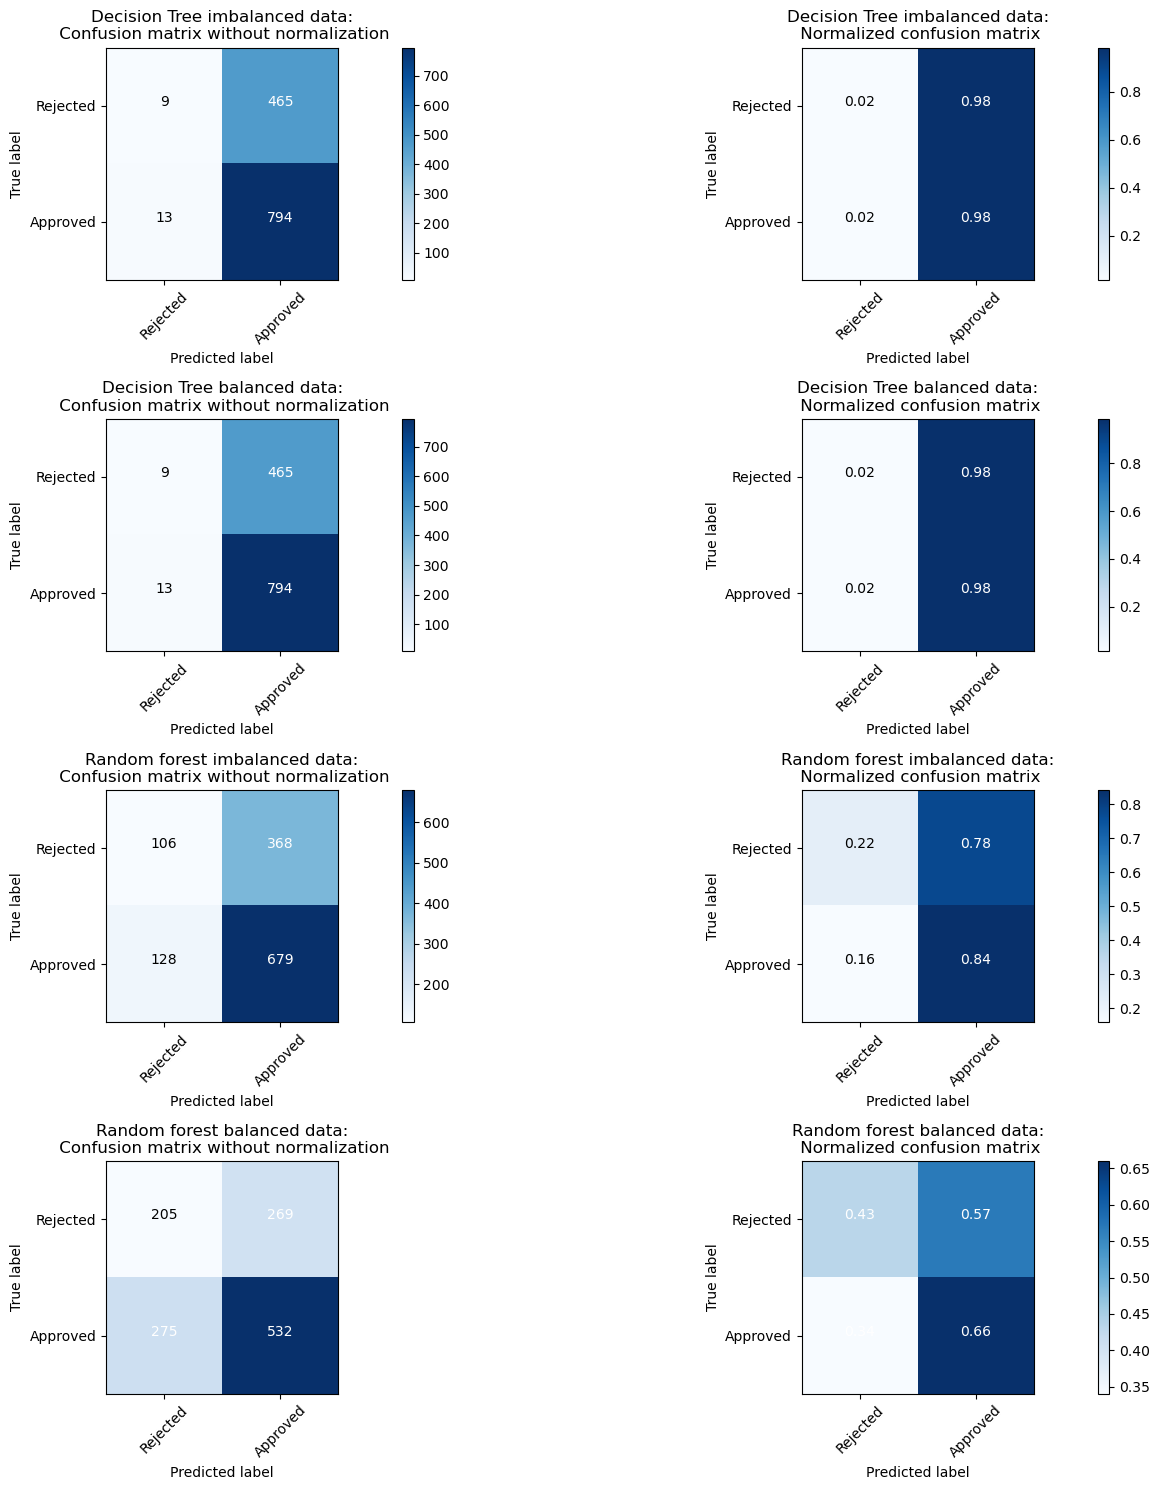

In [26]:
class_names = ['Rejected', 'Approved']
dt_matrix_imb = confusion_matrix(y_test, y_pred)
dt_matrix_bal = confusion_matrix(y_test, y_pred_bdt)
rfc_matrix_imb = confusion_matrix(y_test, y_pred_rfc)
rfc_matrix_bal = confusion_matrix(y_test, y_pred_brfc)

np.set_printoptions(precision=2)

plt.figure(figsize=(20,15))

#Plot imbalanced DecisionTree confusion matrix
plt.subplot(421)
plot_confusion_matrix(dt_matrix_imb, classes=class_names, title='Decision Tree imbalanced data:\n Confusion matrix without normalization')

#Plot imbalanced DecisionTree normalized confusion matrix
plt.subplot(422)
plot_confusion_matrix(dt_matrix_imb, classes=class_names, normalize=True, title='Decision Tree imbalanced data:\n Normalized confusion matrix')

#Plot balanced DecisionTree confusion matrix
plt.subplot(423)
plot_confusion_matrix(dt_matrix_bal, classes=class_names, title='Decision Tree balanced data:\n Confusion matrix without normalization')

#Plot balanced DecisionTree normalized confusion matrix
plt.subplot(424)
plot_confusion_matrix(dt_matrix_bal, classes=class_names, normalize=True, title='Decision Tree balanced data:\n Normalized confusion matrix')

#Plot balanced rf confusion matrix
plt.subplot(425)
plot_confusion_matrix(rfc_matrix_imb, classes=class_names, title='Random forest imbalanced data:\n Confusion matrix without normalization')

#Plot balanced DecisionTree normalized confusion matrix
plt.subplot(426)
plot_confusion_matrix(rfc_matrix_imb, classes=class_names, normalize=True, title='Random forest imbalanced data:\n Normalized confusion matrix')

#Plot balanced rf confusion matrix
plt.subplot(427)
plot_confusion_matrix(rfc_matrix_bal, classes=class_names, title='Random forest balanced data:\n Confusion matrix without normalization')

#Plot balanced DecisionTree normalized confusion matrix
plt.subplot(428)
plot_confusion_matrix(rfc_matrix_bal, classes=class_names, normalize=True, title='Random forest balanced data:\n Normalized confusion matrix')

plt.show()

## ROC and AUC

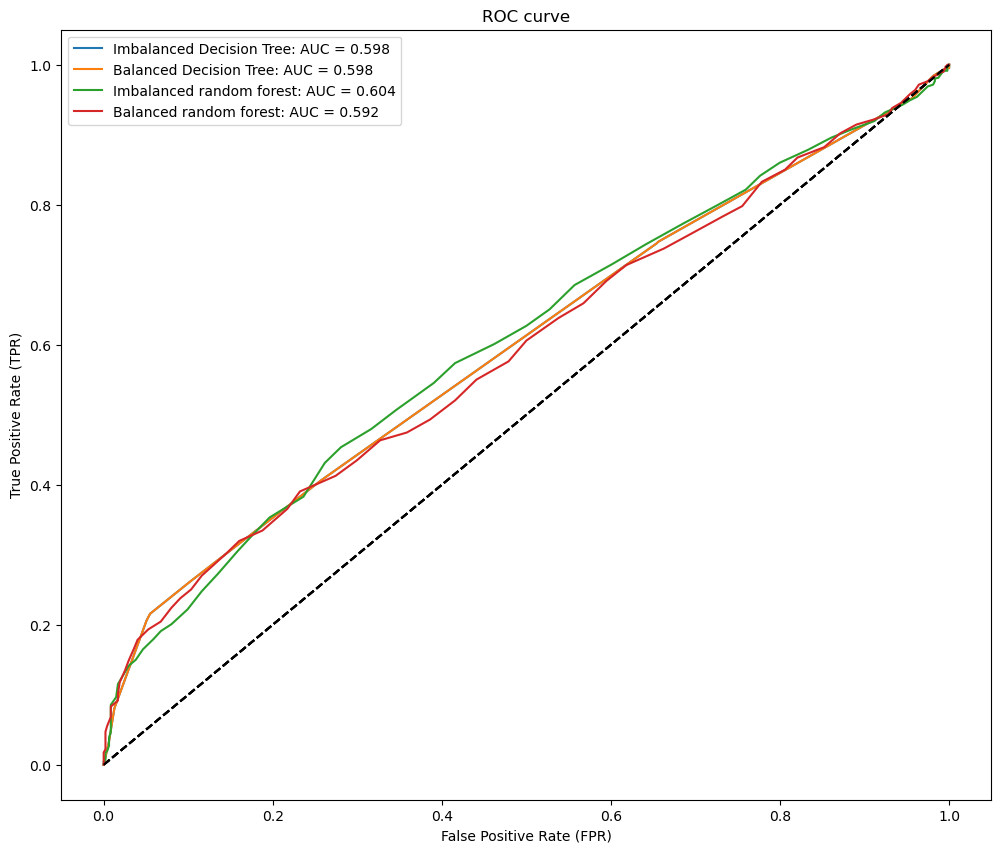

In [27]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test, y_test], [y_prob[:,1], y_prob_bdt[:,1], y_prob_rfc[:,1], y_prob_brfc[:,1]], ['Imbalanced Decision Tree', 'Balanced Decision Tree', 'Imbalanced random forest', 'Balanced random forest']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1], color='black', linestyle='--')

plt.title('ROC curve')
plt.ylabel('True Positive Rate (TPR)') 
plt.xlabel('False Positive Rate (FPR)') 

plt.show()

## Imbalanced random forest sequential feature selection

In [28]:
#rfc_sfs = SFS(
#    rfc,
#    k_features=(1, X_train.shape[1]),
#    forward=True,
#    scoring="accuracy",
#    cv=5,
#    verbose=0,
#    n_jobs=-1
#)
#rfc_sfs.fit(X_train, y_train)

In [29]:
#X_train_balanced_rfc = rfc_sfs.transform(X_train_balanced)
#X_test_rfc = rfc_sfs.transform(X_test)

In [30]:
#plot_sfs(rfc_sfs.get_metric_dict(), ylabel="Accuracy", figsize=(5,3))
#plt.title("rfc forward selection")
#plt.legend(["Standard deviation", "Mean performance"])

In [31]:
#X_train_rfc_sfs = rfc_sfs.transform(X_train)
#X_test_rfc_sfs = rfc_sfs.transform(X_test)

In [32]:
#rfc.fit(X_train_rfc_sfs, y_train)

In [33]:
#y_pred_rfc = rfc.predict(X_test_rfc_sfs)
#y_prob_rfc = rfc.predict_proba(X_test_rfc_sfs)
#print ("VALIDATION Accuracy is: ", (accuracy_score(y_test,y_pred_rfc)*100).round(2))

## Improving the imbalanced random forest

In [40]:
# Create the param grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2'],
    'criterion': ['gini']
}

In [41]:
rfc_gs = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 5, verbose=1, n_jobs = -1, scoring = 'accuracy', refit=True)

In [42]:
%%time
rfc_gs.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
CPU times: user 1.42 s, sys: 171 ms, total: 1.59 s
Wall time: 22.1 s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1234),
             n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['log2'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=1)

In [43]:
rfc_gs.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [44]:
rfc_gs.best_score_

0.6087606370761276

In [45]:
y_pred_rfc_gs = rfc_gs.predict(X_test)
y_prob_rfc_gs = rfc_gs.predict_proba(X_test)
print ("TEST Accuracy is: ", (accuracy_score(y_test,y_pred_rfc_gs)*100).round(2))

TEST Accuracy is:  61.28


## Improving the balanced random forest  

In [ ]:
brfc = RandomForestClassifier(random_state = 1234).fit(X_train_balanced, y_train_balanced)

In [ ]:
y_pred_brfc = brfc.predict(X_val)
y_prob_brfc = brfc.predict_proba(X_val)
print ("VALIDATION Accuracy is: ", (accuracy_score(y_val,y_pred_brfc)*100).round(2))

In [ ]:
# Create the param grid
param_grid = {
    'n_estimators': [175, 180, 185, 190],
    'max_depth': [None],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2],
    'max_features': ['log2'],
    'criterion': ['gini']
}

In [ ]:
brfc_gs = GridSearchCV(estimator = brfc, param_grid = param_grid, cv = 5, verbose=1, n_jobs = -1, scoring = 'accuracy', refit=True)

In [ ]:
%%time
brfc_gs.fit(X_train, y_train)

In [ ]:
brfc_gs.best_params_

In [ ]:
y_pred_brfc_gs = brfc_gs.predict(X_val)
y_prob_brfc_gs = brfc_gs.predict_proba(X_val)
print ("VALIDATION Accuracy is: ", (accuracy_score(y_val,y_pred_brfc_gs)*100).round(2))

In [ ]:
y_pred_brfc_gs_test = brfc_gs.predict(X_test)
y_prob_brfc_gs_test = brfc_gs.predict_proba(X_test)
print ("TEST Accuracy is: ", (accuracy_score(y_test,y_pred_brfc_gs_test)*100).round(2))

## Other models

In [ ]:
##Initial model testing
#X = loans.drop("loan_status", axis=1)
#y = loans["loan_status"]
#
## Scale features
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#
## Split training and testing
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1234, test_size=0.3)
#
## Comparing accuracies
#accs = {"knn":0, "lr":0, "dtc":0, "rfc":0, "svc":0, "mlp":0}

In [ ]:
#knn = KNeighborsClassifier(n_neighbors=7)
#accs["knn"] = cross_val_score(knn, X_train, y_train).mean()

In [ ]:
#lr = LogisticRegression(random_state=1234)
#accs["lr"] = cross_val_score(lr, X_train, y_train).mean()

In [ ]:
#dtc = DecisionTreeClassifier(random_state=1234, max_depth=4, min_samples_leaf=3)
#accs["dtc"] = cross_val_score(dtc, X_train, y_train).mean()

In [ ]:
#rfc = RandomForestClassifier(random_state=1234)
#accs["rfc"] = cross_val_score(rfc, X_train, y_train).mean()

In [ ]:
#svc = SVC(kernel="linear")
#accs["svc"] = cross_val_score(svc, X_train, y_train).mean()

In [ ]:
#mlp = MLPClassifier(activation='identity', solver='sgd', random_state=1234)
#accs["mlp"] = cross_val_score(mlp, X_train, y_train).mean()

In [ ]:
## Assuming you have a list of accuracy scores called accuracy_scores
#accuracy_scores = accs.values()
#
## Create a list of corresponding x-axis values
#x_values = range(len(accuracy_scores))
#
## Plot the bar graph
#plt.bar(x_values, accuracy_scores)
#
## Add labels to the plot
#plt.ylabel('Accuracy')
#plt.title('Accuracy Scores of Different Models')
#plt.xlabel('Models')
#
## Customize the x-axis tick labels if necessary
#plt.xticks(x_values, accs.keys(), rotation=45)
#
## Display the plot
#plt.show()

In [ ]:
#print(accuracy_scores)

## XGBClassifier

In [ ]:
#xgbclass_defaults = XGBClassifier()

In [ ]:
#cross_val_score(xgbclass_defaults, X_train_balanced, y_train_balanced).mean()

In [ ]:
#params = {
#    "max_depth" : optuna.distributions.IntDistribution(1, 20),
#    "learning_rate" : optuna.distributions.FloatDistribution(1e-5, 1., log=True),
#    "gamma" : optuna.distributions.FloatDistribution(1e-5, 1., log=True)
#}
#
#xgbclass = OptunaSearchCV(
#    XGBClassifier(n_jobs=-1),
#    params,
#    n_trials=30,
#    scoring="accuracy",
#    cv=5,
#    n_jobs=1,
#    refit=True,
#    random_state=1234
#) 

In [ ]:
#xgbclass.fit(X_train, y_train)

In [ ]:
#xgbclass.best_score_
#0.6201475605452009
#0.9825974913586887

In [ ]:
#y_pred_xgbclass = xgbclass.predict(X_test)
#accuracy_score(y_test, y_pred_xgbclass)

In [ ]:
#conf_matrix = confusion_matrix(y_test,y_pred_xgbclass)

In [ ]:
#conf_matrix_normalized = conf_matrix/len(y_test)
#conf_matrix_normalized = conf_matrix_normalized.round(4)

In [ ]:
#fig, ax = plt.subplots(figsize=(7.5, 7.5))
#ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
#for i in range(conf_matrix.shape[0]):
#    for j in range(conf_matrix.shape[1]):
#        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
# 
#plt.xlabel('Predictions', fontsize=18)
#plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
#plt.show()

In [ ]:
#fig, ax = plt.subplots(figsize=(7.5, 7.5))
#ax.matshow(conf_matrix_normalized, cmap=plt.cm.Blues, alpha=0.3)
#for i in range(conf_matrix_normalized.shape[0]):
#    for j in range(conf_matrix_normalized.shape[1]):
#        ax.text(x=j, y=i,s=conf_matrix_normalized[i, j], va='center', ha='center', size='xx-large')
# 
#plt.xlabel('Predictions', fontsize=18)
#plt.ylabel('Actuals', fontsize=18)
#plt.title('Confusion Matrix', fontsize=18)
#plt.show()